### Experiment1: Finding relationship of reward's parameters for dealing with hierarchical problem.

#### Objective
- To find the relationship of each reward parameters for deling with hierarchical problem.

#### Setting
- Reward parameters
  - Conflict behavior status: confliction between chosen current behavior and previous behavior.
    - 0: No confliction
    - 1: Confliction

  - BT success status: succession of BT when BT is terminate.
    - 0: Failure
    - 1: Success
  
  - Goal seeking: vary following the pominent goal of the BT task. (Discrete value)

    - Find aruco subtask: *find aruco status*
    - Hold handle subtask: *distance between end-effector and handle*
    - Door traversal subtask: *distance between agent and goal position*

  - Number fo action in BT 

- Action types
  1. Action that cause confliction with previous behavior.
  2. Action that do not cause confliction but do not lead to achieve the goal and status of BT is FAILURE.
  3. Action that do not cause confliction and lead to achieve the goal but status of BT is FAILURE.
  4. Action that do not cause confliction and lead to achieve the goal and status of BT is SUCCESS.

--------------------------------------------------------------------

### Experiment1 : Finding relationship of reward's parameters for dealing with hierarchical problem. (Monte-Carlo) Algorithm

##### 1. Set1

/tmp/ipykernel_7629/3739239201.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GS = torch.load(target_GS)


out_of_range: 2
4001


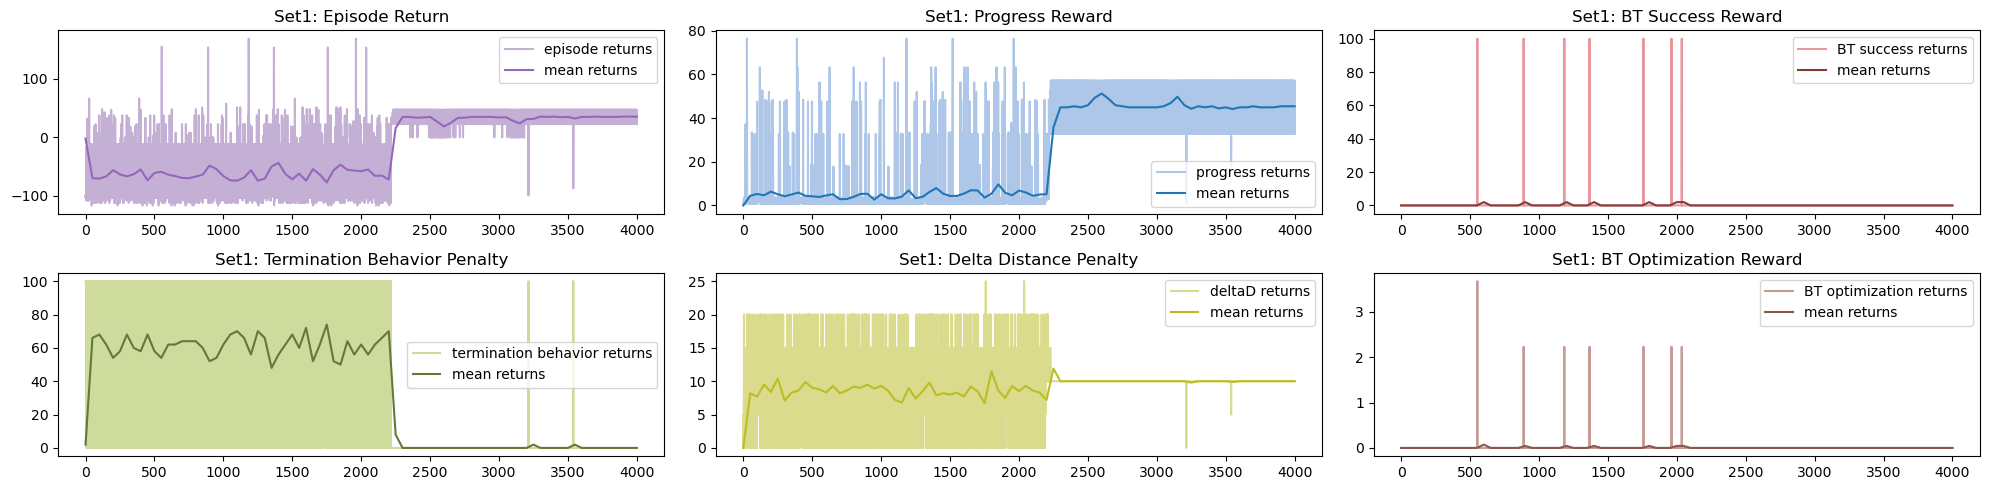

'\nidx_max = 0\n\nfor i in range(len(reward)):\n    if reward[i]== max(reward):#\n        idx_max = i\n\nprint(reward[idx_max])\ntrajec_max = trajectory[1758]\nprint(len(trajec_max))\nfor i in range(len(trajec_max)):\n    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])\n\nprint("exploited BT")\nfor i in range(len(exploit_trajectory)):\n    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])\n\n'

In [72]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX1/EX1_set1.pt' # EXR_HoldHandle_MC_4000_retrain.pt
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1

exploit_trajectory = []
n = 0
filter_num = 1

for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])
        exploit_trajectory = trajectory[i]

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]
    
    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            if k == 1 or k == 3:
                num = -1
            else:
                num = 1
            returns_mean_list[k].append(num*sum_returns[k]/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

    n+=1

    if n%filter_num == 0:
        reward.append(reward_list_GS[i][0])
        returns_sum.append(returns_list[i][5])
        if i%terminate_avg_num == 0:
            returns_progress.append(returns_list[i][0])
            returns_deltaD.append((-1)*returns_list[i][1])
            returns_cb.append((-1)*returns_list[i][3])

        returns_success.append(returns_list[i][2])
        returns_btNum.append(returns_list[i][4])
    
    # if n%5 == 0:
    #     returns = returns_list[i][5]
    #     progress = returns_list[i][0]
    #     deltaD = (-1)*returns_list[i][1]
    #     tb = (-1)*returns_list[i][3]
    #     BTsuccess = returns_list[i][2]
    #     BToptimization = returns_list[i][4]
    # else:
    #     pass

    # # reward.append(reward_list_GS[i][0])
    # returns_sum.append(returns)
    # if i%terminate_avg_num == 0:
    #     returns_progress.append(progress)
    #     returns_deltaD.append(deltaD)
    #     returns_cb.append(tb)

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
# n = 0
# for i in range(len(reward)):
#     n+=1
#     if n%5 == 0:
#         reward_filter.append(reward[i])

print(len_reward_GS)


colors = plt.get_cmap('tab20')
colors_2 = plt.get_cmap('tab20b')
fig, [[axs1, axs2, axs3], [axs4, axs5, axs6]] = plt.subplots(2, 3, figsize = (20, 5))

axs1.set_title("Set1: Episode Return") 
axs2.set_title("Set1: Progress Reward") 
axs3.set_title("Set1: BT Success Reward") 
axs4.set_title("Set1: Termination Behavior Penalty") 
axs5.set_title("Set1: Delta Distance Penalty") 
axs6.set_title("Set1: BT Optimization Reward") 

axs1.plot(np.arange(0,len(returns_sum),1)*filter_num, returns_sum,color=colors(9),label ='episode returns')
axs1.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors(8),label ='mean returns')
axs2.plot(np.arange(0,len(returns_progress),1)*filter_num, returns_progress,color=colors(1),label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors(0),label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1)*filter_num, returns_success,color=colors_2(15),label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors_2(12),label ='mean returns')
axs4.plot(np.arange(0,len(returns_cb),1)*filter_num, returns_cb,color=colors_2(7),label ='termination behavior returns')
axs4.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors_2(4),label ='mean returns')
axs5.plot(np.arange(0,len(returns_deltaD),1)*filter_num, returns_deltaD,color=colors(17),label ='deltaD returns')
axs5.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors(16),label ='mean returns')
axs6.plot(np.arange(0,len(returns_btNum),1)*filter_num, returns_btNum,color=colors(11),label ='BT optimization returns')
axs6.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors(10),label ='mean returns')

axs1.legend()
axs2.legend()
axs3.legend()
axs4.legend()
axs5.legend()
axs6.legend()

plt.tight_layout()

plt.show()
fig.savefig("EX1_Set1_Update.png")

'''
idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[1758]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])

print("exploited BT")
for i in range(len(exploit_trajectory)):
    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])

'''

##### 2. Set2

/tmp/ipykernel_8586/750990440.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GS = torch.load(target_GS)


out_of_range: 594
4000


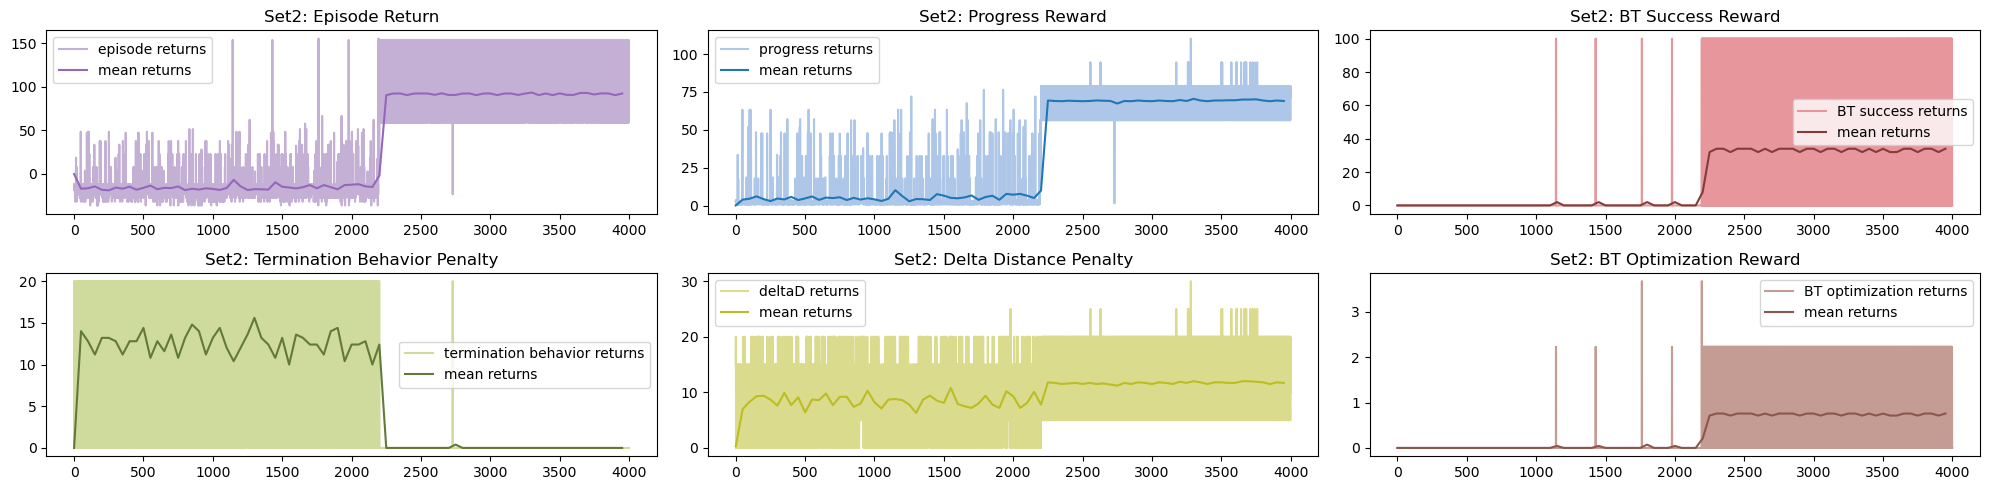

118.67879500776078
4
0 . state: {'find_aruco_status': array([0], dtype=int16), 'have_door_path': array([0], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': '[]'} , action: [0, 0] , reward: 0.738251101634485
1 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': "['s(', {'command': 'CreateDoorPath', 'id': 238}]"} , action: [1, 0] , reward: 15.638593701414862
2 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-1.9, -2.2, -1.4], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX1/EX1_set2.pt' # EXR_set2_HoldHandle_MC_4000
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# n = 0
reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1
exploit_trajectory = []

filter_num = 1

for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])
        exploit_trajectory = trajectory[i]

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    # sum_returns += returns_list[i][5]
    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            if k == 1 or k == 3:
                num = -1
            else:
                num = 1
            returns_mean_list[k].append(num*sum_returns[k]/reward_avg_num)
        # reward_mean_list.append(sum_returns/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]
        # sum_returns = 0.0

    reward.append(reward_list_GS[i][0])
    returns_sum.append(returns_list[i][5])

    if i%terminate_avg_num == 0:
        returns_progress.append(returns_list[i][0])
        returns_deltaD.append((-1)*returns_list[i][1])
        returns_cb.append((-1)*returns_list[i][3])

    # if returns_list[i][2] > 0:
    #     print("success index:",i)
    returns_success.append(returns_list[i][2])
    returns_btNum.append(returns_list[i][4])

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
n = 0
for i in range(len(reward)):
    n+=1
    if n%5 == 0:
        reward_filter.append(reward[i])

print(len_reward_GS)

colors = plt.get_cmap('tab20')
colors_2 = plt.get_cmap('tab20b')
fig, [[axs1, axs2, axs3], [axs4, axs5, axs6]] = plt.subplots(2, 3, figsize = (20, 5))

axs1.set_title("Set2: Episode Return") 
axs2.set_title("Set2: Progress Reward") 
axs3.set_title("Set2: BT Success Reward") 
axs4.set_title("Set2: Termination Behavior Penalty") 
axs5.set_title("Set2: Delta Distance Penalty") 
axs6.set_title("Set2: BT Optimization Reward") 

axs1.plot(np.arange(0,len(returns_sum),1)*filter_num, returns_sum,color=colors(9),label ='episode returns')
axs1.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors(8),label ='mean returns')
axs2.plot(np.arange(0,len(returns_progress),1)*filter_num, returns_progress,color=colors(1),label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors(0),label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1)*filter_num, returns_success,color=colors_2(15),label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors_2(12),label ='mean returns')
axs4.plot(np.arange(0,len(returns_cb),1)*filter_num, returns_cb,color=colors_2(7),label ='termination behavior returns')
axs4.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors_2(4),label ='mean returns')
axs5.plot(np.arange(0,len(returns_deltaD),1)*filter_num, returns_deltaD,color=colors(17),label ='deltaD returns')
axs5.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors(16),label ='mean returns')
axs6.plot(np.arange(0,len(returns_btNum),1)*filter_num, returns_btNum,color=colors(11),label ='BT optimization returns')
axs6.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors(10),label ='mean returns')

axs1.legend()
axs2.legend()
axs3.legend()
axs4.legend()
axs5.legend()
axs6.legend()

plt.tight_layout()

plt.show()
fig.savefig("EX1_Set2_Update.png")

idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        # print(reward[i])
        # print(i)
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[1143]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])

print("exploited BT")
for i in range(len(exploit_trajectory)):
    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])

##### 3. Set3

/tmp/ipykernel_8586/2473867585.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GS = torch.load(target_GS)


out_of_range: 0
4000


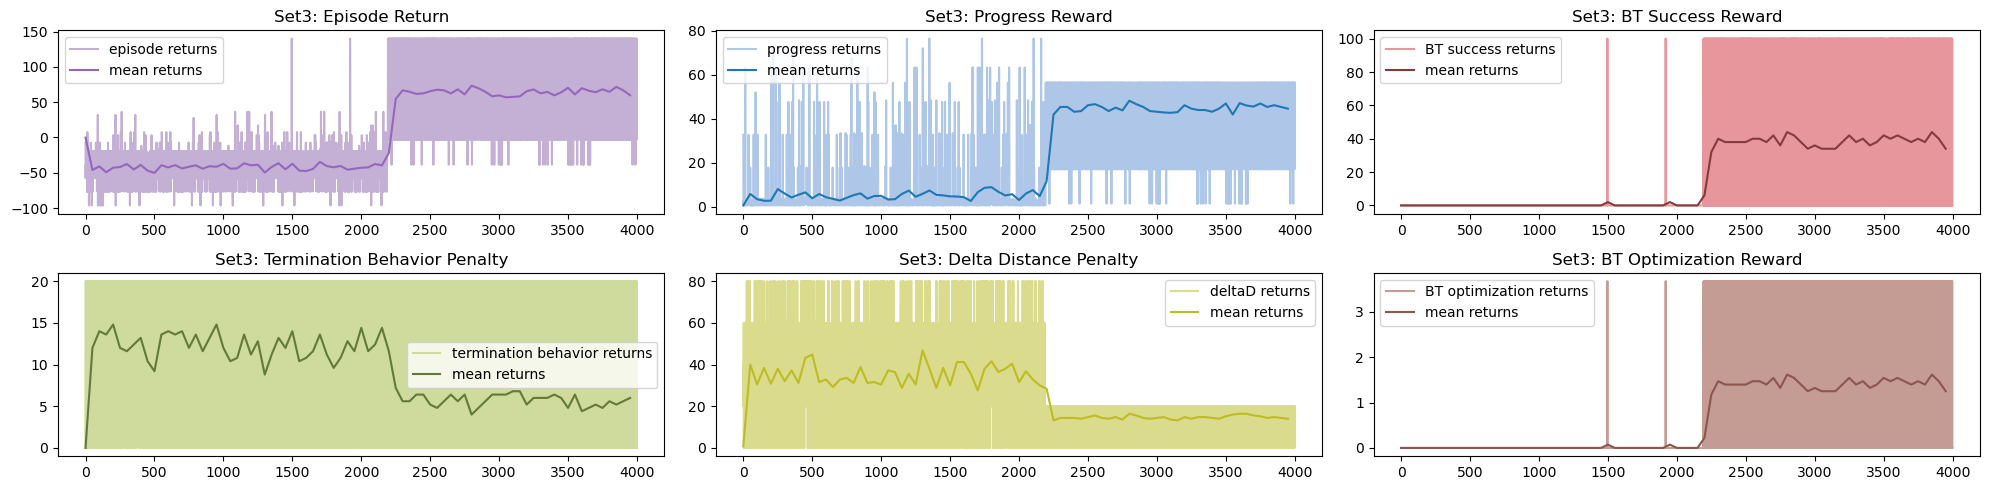

103.67879500776078
4
0 . state: {'find_aruco_status': array([0], dtype=int16), 'have_door_path': array([0], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': '[]'} , action: [0, 0] , reward: 0.738251101634485
1 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': "[{'command': 'CreateDoorPath', 'id': 238}]"} , action: [1, 0] , reward: 15.638593701414862
2 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-1.9, -2.2, -1.4], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], d

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX1/EX1_set3.pt' # EXR_set3_HoldHandle_MC_4000
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# n = 0
reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1
exploit_trajectory = []
filter_num = 1
for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])
        exploit_trajectory = trajectory[i]

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    # sum_returns += returns_list[i][5]
    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            if k == 1 or k == 3:
                num = -1
            else:
                num = 1
            returns_mean_list[k].append(num*sum_returns[k]/reward_avg_num)
        # reward_mean_list.append(sum_returns/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]
        # sum_returns = 0.0

    reward.append(reward_list_GS[i][0])
    returns_sum.append(returns_list[i][5])

    if i%terminate_avg_num == 0:
        returns_progress.append(returns_list[i][0])
        returns_deltaD.append((-1)*returns_list[i][1])
        returns_cb.append((-1)*returns_list[i][3])

    # if returns_list[i][2] > 0:
    #     print("success index:",i)
    returns_success.append(returns_list[i][2])
    returns_btNum.append(returns_list[i][4])

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
n = 0
for i in range(len(reward)):
    n+=1
    if n%5 == 0:
        reward_filter.append(reward[i])

print(len_reward_GS)


colors = plt.get_cmap('tab20')
colors_2 = plt.get_cmap('tab20b')
fig, [[axs1, axs2, axs3], [axs4, axs5, axs6]] = plt.subplots(2, 3, figsize = (20, 5))

axs1.set_title("Set3: Episode Return") 
axs2.set_title("Set3: Progress Reward") 
axs3.set_title("Set3: BT Success Reward") 
axs4.set_title("Set3: Termination Behavior Penalty") 
axs5.set_title("Set3: Delta Distance Penalty") 
axs6.set_title("Set3: BT Optimization Reward") 

axs1.plot(np.arange(0,len(returns_sum),1)*filter_num, returns_sum,color=colors(9),label ='episode returns')
axs1.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors(8),label ='mean returns')
axs2.plot(np.arange(0,len(returns_progress),1)*filter_num, returns_progress,color=colors(1),label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors(0),label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1)*filter_num, returns_success,color=colors_2(15),label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors_2(12),label ='mean returns')
axs4.plot(np.arange(0,len(returns_cb),1)*filter_num, returns_cb,color=colors_2(7),label ='termination behavior returns')
axs4.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors_2(4),label ='mean returns')
axs5.plot(np.arange(0,len(returns_deltaD),1)*filter_num, returns_deltaD,color=colors(17),label ='deltaD returns')
axs5.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors(16),label ='mean returns')
axs6.plot(np.arange(0,len(returns_btNum),1)*filter_num, returns_btNum,color=colors(11),label ='BT optimization returns')
axs6.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors(10),label ='mean returns')

axs1.legend()
axs2.legend()
axs3.legend()
axs4.legend()
axs5.legend()
axs6.legend()

plt.tight_layout()

plt.show()
fig.savefig("EX1_Set3_Update.png")

idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        # print(reward[i])
        # print(i)
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[idx_max]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])

print("exploited BT")
for i in range(len(exploit_trajectory)):
    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])

---------------------------------------------------------------

#### Experiment2 : Policy Algorithm with weight fromset3 in experiment1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


out_of_range: 2
4000


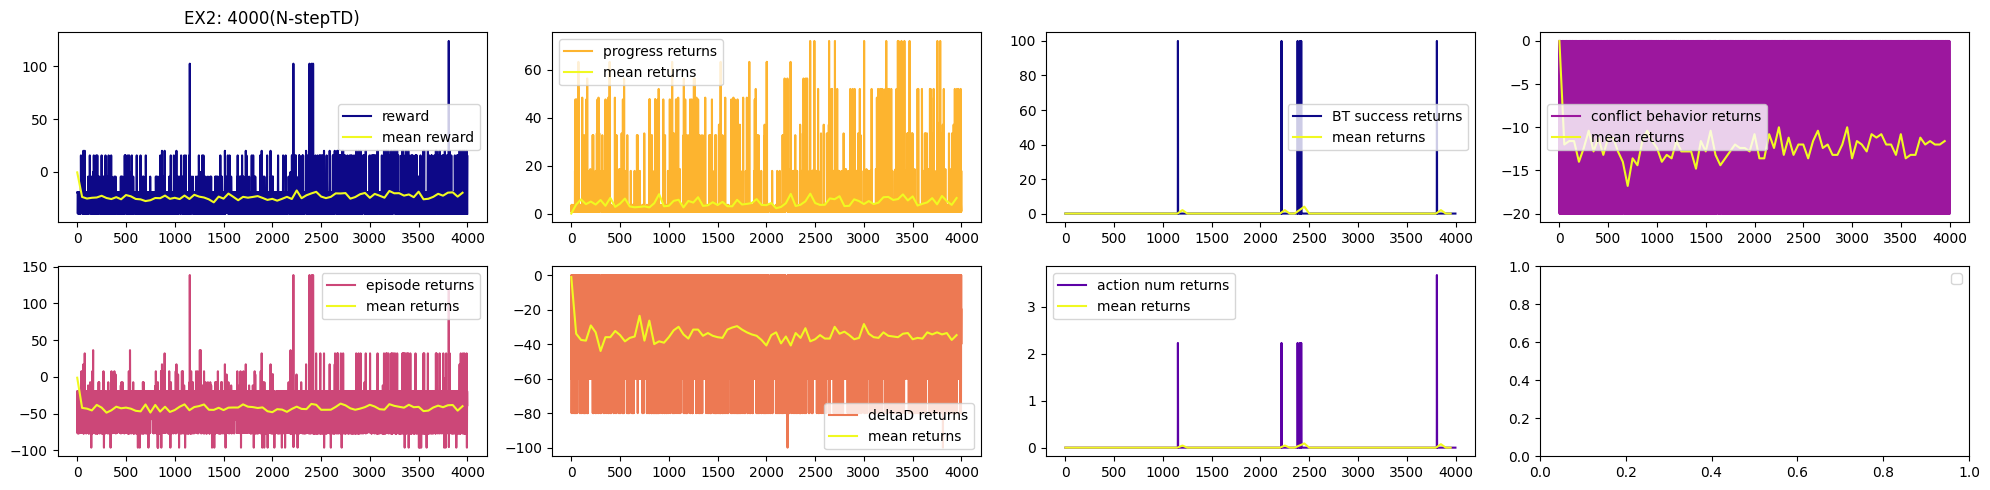

123.67879500776078
4
0 . state: {'find_aruco_status': array([0], dtype=int16), 'have_door_path': array([0], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': '[]'} , action: [3, 0] , reward: 0.738251101634485
1 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([0], dtype=int16), 'gripper_status': array([0], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': "['s(', {'command': 'ClosedGripper'}]"} , action: [0, 0] , reward: -19.261748898365514
2 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([0], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX2/EX2_nStepTD.pt' # EXA_set3_HoldHandle_nstepTD_4000
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# n = 0
reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1
exploit_trajectory = []
for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])
        exploit_trajectory = trajectory[i]

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    # sum_returns += returns_list[i][5]
    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            returns_mean_list[k].append(sum_returns[k]/reward_avg_num)
        # reward_mean_list.append(sum_returns/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]
        # sum_returns = 0.0

    reward.append(reward_list_GS[i][0])
    returns_sum.append(returns_list[i][5])

    if i%terminate_avg_num == 0:
        returns_progress.append(returns_list[i][0])
        returns_deltaD.append(returns_list[i][1])
        returns_cb.append(returns_list[i][3])

    # if returns_list[i][2] > 0:
    #     print("success index:",i)
    returns_success.append(returns_list[i][2])
    returns_btNum.append(returns_list[i][4])

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
n = 0
for i in range(len(reward)):
    n+=1
    if n%5 == 0:
        reward_filter.append(reward[i])

print(len_reward_GS)

import matplotlib as mpl

n_lines = 7
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, n_lines))
fig, [[axs1, axs2, axs3,ax42], [axs5, axs6, axs7,axs8]] = plt.subplots(2, 4, figsize = (20, 5))
# plt.plot(np.arange(0,len(reward),1), reward)
axs1.set_title("EX2: 4000(N-stepTD)") 
axs1.plot(np.arange(0,len(reward),1), reward,color=colors[0],label ='reward')
axs1.plot(np.arange(0,len(reward_mean_list),1)*reward_avg_num, reward_mean_list,color=colors[6],label ='mean reward')
axs1.legend()

# axs2.plot(np.arange(0,len(terminate1_list),1)*terminate_avg_num, terminate1_list,color=colors[5],label ='1 action')
# axs2.plot(np.arange(0,len(terminate2_list),1)*terminate_avg_num, terminate2_list,color=colors[4],label ='2 actions')
# axs2.plot(np.arange(0,len(terminate3_list),1)*terminate_avg_num, terminate3_list,color=colors[3],label ='3 actions')
# axs2.plot(np.arange(0,len(terminate5_list),1)*terminate_avg_num, terminate5_list,color=colors[1],label ='5 actions')
# axs2.set_title("Number of BT Termination") 
axs5.plot(np.arange(0,len(returns_sum),1), returns_sum,color=colors[3],label ='episode returns')
axs5.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors[6],label ='mean returns')

axs2.plot(np.arange(0,len(returns_progress),1), returns_progress,color=colors[5],label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors[6],label ='mean returns')
axs6.plot(np.arange(0,len(returns_deltaD),1), returns_deltaD,color=colors[4],label ='deltaD returns')
axs6.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors[6],label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1), returns_success,color=colors[0],label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors[6],label ='mean returns')
ax42.plot(np.arange(0,len(returns_cb),1), returns_cb,color=colors[2],label ='conflict behavior returns')
ax42.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors[6],label ='mean returns')

axs7.plot(np.arange(0,len(returns_btNum),1), returns_btNum,color=colors[1],label ='action num returns')
axs7.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors[6],label ='mean returns')

# plt.plot(np.arange(0,len_reward_exploit,1), reward_exploit)
# plt.plot(np.arange(0,len_reward_explore,1), reward_explore)
axs2.legend()
axs3.legend()
ax42.legend()
axs5.legend()
axs6.legend()
axs7.legend()
axs8.legend()
# for adjusting the space between subplots
plt.tight_layout()
# plt.suptitle('EX1: GS 2000(Q-lerning)')
plt.show()
fig.savefig("EX2_4000(N-stepTD).png")
# print(max(reward_list_18))

idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        # print(reward[i])
        # print(i)
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[idx_max]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])

print("exploited BT")
for i in range(len(exploit_trajectory)):
    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


out_of_range: 116
4000


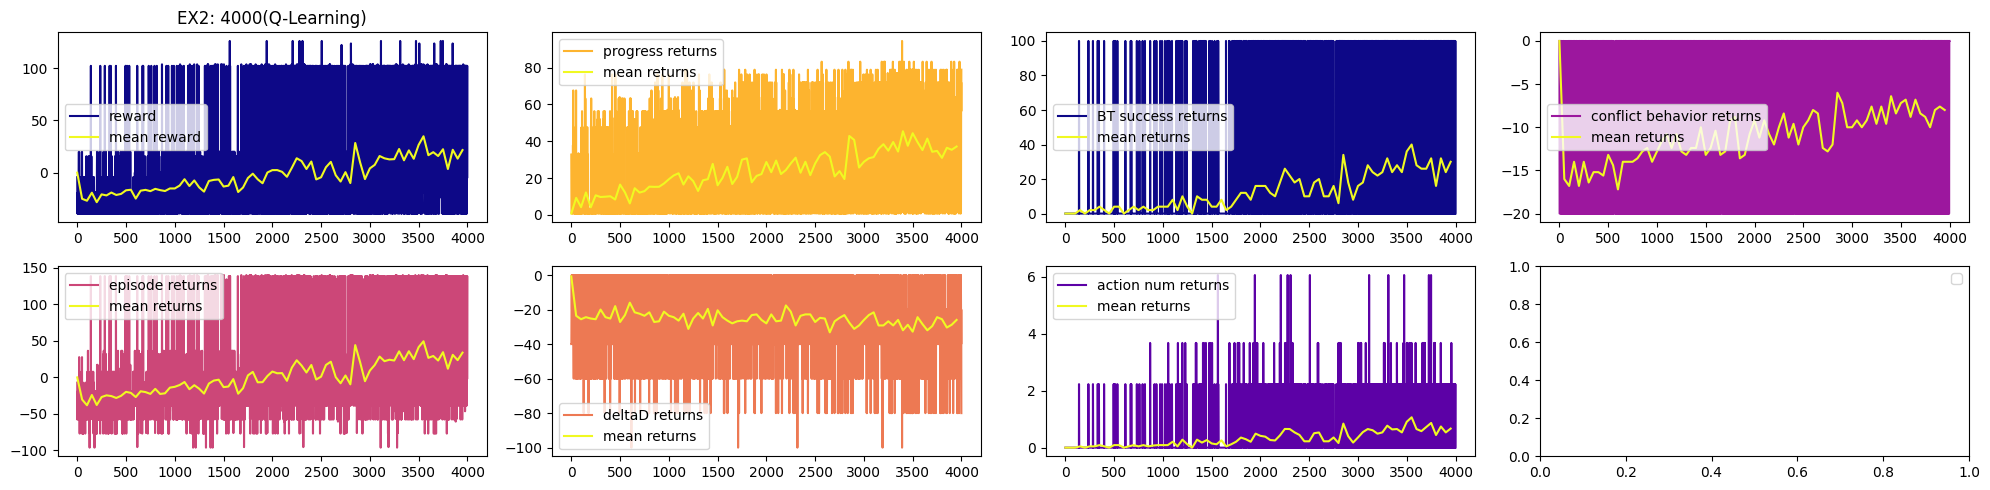

126.0653071931727
4
0 . state: {'find_aruco_status': array([0], dtype=int16), 'have_door_path': array([0], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': '[]'} , action: [0, 0] , reward: 0.738251101634485
1 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': "[{'command': 'CreateDoorPath', 'id': 238}]"} , action: [3, 0] , reward: -19.261748898365514
2 . state: {'find_aruco_status': array([1], dtype=int16), 'have_door_path': array([1], dtype=int16), 'gripper_status': array([0], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], d

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX2/EX2_QLearning.pt' # EXA_set3_HoldHandle_QL_4000
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# n = 0
reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1
exploit_trajectory = []
for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])
        exploit_trajectory = trajectory[i]

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    # sum_returns += returns_list[i][5]
    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            returns_mean_list[k].append(sum_returns[k]/reward_avg_num)
        # reward_mean_list.append(sum_returns/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]
        # sum_returns = 0.0

    reward.append(reward_list_GS[i][0])
    returns_sum.append(returns_list[i][5])

    if i%terminate_avg_num == 0:
        returns_progress.append(returns_list[i][0])
        returns_deltaD.append(returns_list[i][1])
        returns_cb.append(returns_list[i][3])

    # if returns_list[i][2] > 0:
    #     print("success index:",i)
    returns_success.append(returns_list[i][2])
    returns_btNum.append(returns_list[i][4])

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
n = 0
for i in range(len(reward)):
    n+=1
    if n%5 == 0:
        reward_filter.append(reward[i])

print(len_reward_GS)

import matplotlib as mpl

n_lines = 7
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, n_lines))
fig, [[axs1, axs2, axs3,ax42], [axs5, axs6, axs7,axs8]] = plt.subplots(2, 4, figsize = (20, 5))
# plt.plot(np.arange(0,len(reward),1), reward)
axs1.set_title("EX2: 4000(Q-Learning)") 
axs1.plot(np.arange(0,len(reward),1), reward,color=colors[0],label ='reward')
axs1.plot(np.arange(0,len(reward_mean_list),1)*reward_avg_num, reward_mean_list,color=colors[6],label ='mean reward')
axs1.legend()

# axs2.plot(np.arange(0,len(terminate1_list),1)*terminate_avg_num, terminate1_list,color=colors[5],label ='1 action')
# axs2.plot(np.arange(0,len(terminate2_list),1)*terminate_avg_num, terminate2_list,color=colors[4],label ='2 actions')
# axs2.plot(np.arange(0,len(terminate3_list),1)*terminate_avg_num, terminate3_list,color=colors[3],label ='3 actions')
# axs2.plot(np.arange(0,len(terminate5_list),1)*terminate_avg_num, terminate5_list,color=colors[1],label ='5 actions')
# axs2.set_title("Number of BT Termination") 
axs5.plot(np.arange(0,len(returns_sum),1), returns_sum,color=colors[3],label ='episode returns')
axs5.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors[6],label ='mean returns')

axs2.plot(np.arange(0,len(returns_progress),1), returns_progress,color=colors[5],label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors[6],label ='mean returns')
axs6.plot(np.arange(0,len(returns_deltaD),1), returns_deltaD,color=colors[4],label ='deltaD returns')
axs6.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors[6],label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1), returns_success,color=colors[0],label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors[6],label ='mean returns')
ax42.plot(np.arange(0,len(returns_cb),1), returns_cb,color=colors[2],label ='conflict behavior returns')
ax42.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors[6],label ='mean returns')

axs7.plot(np.arange(0,len(returns_btNum),1), returns_btNum,color=colors[1],label ='action num returns')
axs7.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors[6],label ='mean returns')

# plt.plot(np.arange(0,len_reward_exploit,1), reward_exploit)
# plt.plot(np.arange(0,len_reward_explore,1), reward_explore)
axs2.legend()
axs3.legend()
ax42.legend()
axs5.legend()
axs6.legend()
axs7.legend()
axs8.legend()
# for adjusting the space between subplots
plt.tight_layout()
# plt.suptitle('EX1: GS 2000(Q-lerning)')
plt.show()
fig.savefig("EX2_4000(Q-Learning).png")
# print(max(reward_list_18))

idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        # print(reward[i])
        # print(i)
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[3473]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])

print("exploited BT")
for i in range(len(exploit_trajectory)):
    print(". state:",exploit_trajectory[i][0],", action:",exploit_trajectory[i][1],", reward:",exploit_trajectory[i][2])

-------------------------------------------------------------

### Door traversal

/tmp/ipykernel_8586/2051114326.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GS = torch.load(target_GS)


out_of_range: 1251
4855


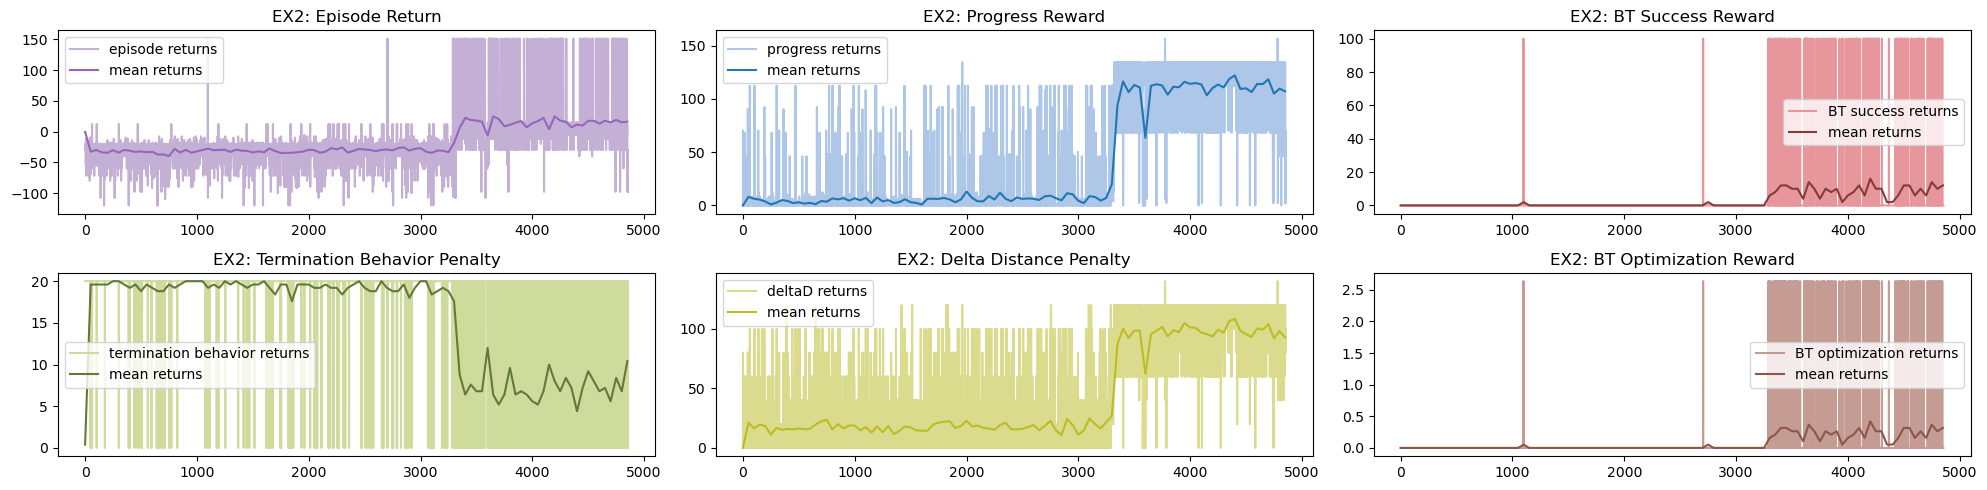

142.63597109172653
5
0 . state: {'hold_handle_status': array([0], dtype=int16), 'door_status': array([0], dtype=int16), 'gripper_status': array([1], dtype=int16), 'robot_pose': array([-2. , -1.5, -1.8], dtype=float32), 'gripper_base_pose': array([0.4, 0.1, 1. , 1.5, 0. , 0. ], dtype=float32), 'BT_string': '[]'} , action: [0, 0] , reward: 2.060677891175314
1 . state: {'hold_handle_status': array([1], dtype=int16), 'door_status': array([0], dtype=int16), 'gripper_status': array([0], dtype=int16), 'robot_pose': array([-1.9, -2.2, -1.4], dtype=float32), 'gripper_base_pose': array([0.8, 0.2, 1. , 1.5, 0. , 0.2], dtype=float32), 'BT_string': "['s(', 'f(', {'command': 'isHoldHandle', 'name': '0'}, 's(', {'command': 'CreateDoorPath', 'name': '0', 'id': 238}, {'command': 'MMApproachDoor', 'id': 238}, {'command': 'MMMoveLinear', 'name': '0'}, {'command': 'ClosedGripper'}, ')', ')']"} , action: [1, 0] , reward: 2.060677891175313
2 . state: {'hold_handle_status': array([1], dtype=int16), 'door_sta

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

target_GS = 'model/EX3/EX3_DoorTraversal_MC_6000.pt' # EX_DoorTraversal_MC_6000_retrain14
model_GS = torch.load(target_GS)

reward_list_GS = model_GS['reward_report']
trajectory = model_GS["trajectory_memory"]
returns_list = model_GS["return_memory"]

len_reward_GS = len(reward_list_GS)
reward_exploit = []
reward_explore = []
reward = []
returns_sum = []
returns_progress = []
returns_deltaD = []
returns_success = []
returns_cb = []
returns_btNum = []

# n = 0
reward_filter = []
sum_reward = 0.0
sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]

reward_mean_list = []
terminate1_list = []
terminate2_list = []
terminate3_list = []
terminate4_list = []
terminate5_list = []
terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

returns_mean_list = [[],[],[],[],[],[]]

out_of_range = 0
reward_avg_num = 50
terminate_avg_num = 1

for i in range(len(reward_list_GS)):
    is_exploit = 1
    for j in range(len(reward_list_GS[i][1])):
        if reward_list_GS[i][1][j] == 0:
            is_exploit = 0
            reward_explore.append(reward_list_GS[i][0])
            break
    if is_exploit == 1:
        reward_exploit.append(reward_list_GS[i][0])

    sum_reward += reward_list_GS[i][0]
    terminate_num = len(trajectory[i])
    if terminate_num <= 5:
        terminate_num_list[terminate_num-1] += 1
    else:
        out_of_range += 1

    # sum_returns += returns_list[i][5]
    if i%terminate_avg_num == 0:
        terminate1_list.append(terminate_num_list[0])
        terminate2_list.append(terminate_num_list[1])
        terminate3_list.append(terminate_num_list[2])
        terminate4_list.append(terminate_num_list[3])
        terminate5_list.append(terminate_num_list[4])
        terminate_num_list = [0.0, 0.0, 0.0, 0.0, 0.0]

    if returns_list[i][2] < 0:
        returns_list[i][2] = 0.0
        returns_list[i][4] = 0.0
        returns_list[i][5] = 0.0
        old_reward = list(reward_list_GS[i])
        old_reward[0]+=100.0
        reward_list_GS[i] = tuple(old_reward)
    if returns_list[i][3] > 0:
        returns_list[i][3] = 0.0
        returns_list[i][5] = 0.0

    for j in range(len(sum_returns)):
        sum_returns[j] += returns_list[i][j]

    if i%reward_avg_num == 0:
        reward_mean_list.append(sum_reward/reward_avg_num)
        for k in range(len(sum_returns)):
            if k == 1 or k == 3:
                num = -1
            else:
                num = 1
            returns_mean_list[k].append(num*sum_returns[k]/reward_avg_num)
        # reward_mean_list.append(sum_returns/reward_avg_num)
        
        sum_reward = 0.0
        sum_returns = [0.0,0.0,0.0,0.0,0.0,0.0]
        # sum_returns = 0.0

    reward.append(reward_list_GS[i][0])
    returns_sum.append(returns_list[i][5])

    if i%terminate_avg_num == 0:
        returns_progress.append(returns_list[i][0])
        returns_deltaD.append((-1)*returns_list[i][1])
        returns_cb.append((-1)*returns_list[i][3])

    # if returns_list[i][2] > 0:
    #     print("success index:",i)
    returns_success.append(returns_list[i][2])
    returns_btNum.append(returns_list[i][4])

len_reward_exploit = len(reward_exploit)
len_reward_explore = len(reward_explore)
print("out_of_range:",out_of_range)
n = 0
for i in range(len(reward)):
    n+=1
    if n%5 == 0:
        reward_filter.append(reward[i])

print(len_reward_GS)


colors = plt.get_cmap('tab20')
colors_2 = plt.get_cmap('tab20b')
fig, [[axs1, axs2, axs3], [axs4, axs5, axs6]] = plt.subplots(2, 3, figsize = (20, 5))

axs1.set_title("EX2: Episode Return") 
axs2.set_title("EX2: Progress Reward") 
axs3.set_title("EX2: BT Success Reward") 
axs4.set_title("EX2: Termination Behavior Penalty") 
axs5.set_title("EX2: Delta Distance Penalty") 
axs6.set_title("EX2: BT Optimization Reward") 

axs1.plot(np.arange(0,len(returns_sum),1)*filter_num, returns_sum,color=colors(9),label ='episode returns')
axs1.plot(np.arange(0,len(returns_mean_list[5]),1)*reward_avg_num, returns_mean_list[5],color=colors(8),label ='mean returns')
axs2.plot(np.arange(0,len(returns_progress),1)*filter_num, returns_progress,color=colors(1),label ='progress returns')
axs2.plot(np.arange(0,len(returns_mean_list[0]),1)*reward_avg_num, returns_mean_list[0],color=colors(0),label ='mean returns')
axs3.plot(np.arange(0,len(returns_success),1)*filter_num, returns_success,color=colors_2(15),label ='BT success returns')
axs3.plot(np.arange(0,len(returns_mean_list[2]),1)*reward_avg_num, returns_mean_list[2],color=colors_2(12),label ='mean returns')
axs4.plot(np.arange(0,len(returns_cb),1)*filter_num, returns_cb,color=colors_2(7),label ='termination behavior returns')
axs4.plot(np.arange(0,len(returns_mean_list[3]),1)*reward_avg_num, returns_mean_list[3],color=colors_2(4),label ='mean returns')
axs5.plot(np.arange(0,len(returns_deltaD),1)*filter_num, returns_deltaD,color=colors(17),label ='deltaD returns')
axs5.plot(np.arange(0,len(returns_mean_list[1]),1)*reward_avg_num, returns_mean_list[1],color=colors(16),label ='mean returns')
axs6.plot(np.arange(0,len(returns_btNum),1)*filter_num, returns_btNum,color=colors(11),label ='BT optimization returns')
axs6.plot(np.arange(0,len(returns_mean_list[4]),1)*reward_avg_num, returns_mean_list[4],color=colors(10),label ='mean returns')

axs1.legend()
axs2.legend()
axs3.legend()
axs4.legend()
axs5.legend()
axs6.legend()

plt.tight_layout()

plt.show()
fig.savefig("EX2_Update.png")

idx_max = 0

for i in range(len(reward)):
    if reward[i]== max(reward):#
        # print(reward[i])
        # print(i)
        idx_max = i

print(reward[idx_max])
trajec_max = trajectory[idx_max]
print(len(trajec_max))
for i in range(len(trajec_max)):
    print(i,". state:",trajec_max[i][0],", action:",trajec_max[i][1],", reward:",trajec_max[i][2])